## Vertical Coherence

This notebook expands the analysis of the vertical, horizontal and 2D spectra of along isopycnal tracers to vertical coherence.  

We do the analysis in isopycnal space for the horizontal, and use the mean depth of the isopycnal as the vertical coordinate. 

We follow the approach from Klymak et al 2015. Some notes on calculation can be found here: https://math.bu.edu/people/mak/papers/Kramer_SFN_Short_Course.pdf 

In [1]:
import numpy as np
import xarray as xr

import glidertools as gt
import matplotlib.pylab as plt
from matplotlib.colors import BoundaryNorm

from cmocean import cm as cmo

import xrft 

import gsw

In [2]:
import extra_funcs as ef

In [3]:
plt.style.use('seaborn-colorblind')
plt.rcParams['font.size'] = 8

In [4]:
ds_659_rho = xr.open_dataset('../data/sg_659_iso_grid.nc')
ds_660_rho = xr.open_dataset('../data/sg_660_iso_grid.nc')

In [5]:
# compute spice 
# Pick constant alpha and beta for convenience (can always update later)
alpha_659 = gsw.alpha(ds_659_rho.SA, ds_659_rho.CT, ds_659_rho.ctd_pressure)
alpha_660 = gsw.alpha(ds_660_rho.SA, ds_660_rho.CT, ds_660_rho.ctd_pressure)

# remove a mean per isopycnal
dCT = ds_659_rho.CT  - ds_659_rho.CT.mean('dives')
dSA = ds_659_rho.SA - ds_659_rho.SA.mean('dives')

ds_659_rho['Spice'] = (2*alpha_659*dCT).rename('Spice')

# remove a mean per isopycnal
dCT = ds_660_rho.CT  - ds_660_rho.CT.mean('dives')
dSA = ds_660_rho.SA - ds_660_rho.SA.mean('dives')

ds_660_rho['Spice'] = (2*alpha_660*dCT ).rename('Spice')

When computing the spectra in vertical coordinate we did rescaling of the vertical coordinate from Z to Z_tilde, where the rescaling when like N/f. This was based on Smith and Ferrari 09, which showed that the spectra are isotropic in this rescaled space. So essentially we were trying to use the vertical spectra to guess the horizontal spectra, assuming that the QG scaling holds. 
Here instead when we estimate the 2D spectra directly, we try to estimate what is actually going on rather than trying to use the QG hypothesis. The result can then be checked for isotropy etc. 


In [14]:
ds_659_rho

<xarray.Dataset>
Dimensions:       (rho_grid: 1001, dives: 912)
Coordinates:
  * rho_grid      (rho_grid) float64 26.8 26.8 26.8 26.8 ... 27.8 27.8 27.8 27.8
  * dives         (dives) float64 2.0 2.5 3.0 3.5 ... 461.0 461.5 462.0 462.5
Data variables:
    ctd_pressure  (rho_grid, dives) float64 ...
    CT            (rho_grid, dives) float64 nan nan nan nan ... nan nan nan nan
    SA            (rho_grid, dives) float64 nan nan nan nan ... nan nan nan nan
    Oxygen        (rho_grid, dives) float64 ...
    latitude      (rho_grid, dives) float64 ...
    longitude     (rho_grid, dives) float64 ...
    days          (rho_grid, dives) float64 ...
    Spice         (rho_grid, dives) float64 nan nan nan nan ... nan nan nan nan

### Horizontal-vertical 2D wavenumber spectrum over the striaght section

In [6]:
# select straight section
ds_660_scX = ds_660_rho.sel(dives=slice(225, 337))#.sel(ctd_pressure=500, method='nearest')
ds_659_scX = ds_659_rho.sel(dives=slice(182, 287))#.sel(ctd_pressure=500, method='nearest')

In [9]:
import scipy.interpolate as interpolate

def interp_distance(ds, var): 
    #dist_grid = np.arange(20e3, 475e3, 500)
    dist_grid = np.arange(0, 416e3, 500)
    
    for i in range(len(ds.rho_grid)): 
        ds_temp = ds.isel(rho_grid=i)
        
        
        #distance = np.cumsum(gt.utils.distance(np.insert(ds_temp.longitude, 0, 33), 
        #                                       np.insert(ds_temp.latitude, 0, -50)))
        #data = np.insert(ds_temp[var].values, 0 , 0)
                           
        distance = np.cumsum(gt.utils.distance(ds_temp.longitude, ds_temp.latitude)) 
        data = ds_temp[var].values
        f = interpolate.interp1d(distance, data)
        
        var_int = f(dist_grid)
        
        da_var_int_temp = xr.DataArray(var_int,
                                 dims=["distance"],
                                 coords={"distance": dist_grid, "rho_grid": ds_temp.rho_grid}
                                 ).rename(var)
        
        if i==0:
            da_var_int = da_var_int_temp
        else:
            da_var_int = xr.concat([da_var_int, da_var_int_temp], dim='rho_grid')
        
    return da_var_int
            

In [10]:
ds_659_dist_sec = xr.merge( [interp_distance(ds_659_scX, 'Spice')] )
ds_660_dist_sec = xr.merge( [interp_distance(ds_660_scX, 'Spice')] )

In [11]:
# Function that regrids a single dive 
# Will be rung in a loop to do interpolation for all dives.

def func_var_int_pmean_dist(ds, Pmean_smooth_time): 
    Pmean_grid = np.linspace(0,1000,501)
    
    Pmean = Pmean_smooth_time
 
    ds_nonan = ds.where(~np.isnan(ds) & ~np.isnan(Pmean), drop=True)
    Pmean_nonan = Pmean.where(~np.isnan(ds) & ~np.isnan(Pmean), drop=True)
    
    if len(ds_nonan) > 2:
        f = interpolate.PchipInterpolator(Pmean_nonan.values, ds_nonan.values , extrapolate=False)
        ds_on_Pmean = f(Pmean_grid)
    else:
        ds_on_Pmean = np.nan*Pmean_grid
    
    return xr.DataArray(ds_on_Pmean.reshape((-1,1)),
                        dims = ['Pmean', 'distance'],
                        coords = {'Pmean': Pmean_grid, 'distance': [ds.distance.values]})
    

In [15]:
# For 659
time_ind = 0

Pmean_smooth_time = ds_659_rho.ctd_pressure.mean('dives').rolling(rho_grid= 30, center=True).mean().sel(rho_grid=slice(27.2, 27.69))
# use the same Pmean as what we got from time because it is smoother.
spice_on_Pmean_659_sec = func_var_int_pmean_dist(ds_659_dist_sec.Spice.isel(distance=0), 
                                            Pmean_smooth_time)

for dist_ind in range(1, len(ds_659_dist_sec.distance)):
    if np.mod(dist_ind, 400)==0:
        print(dist_ind)
    spice_on_Pmean_659_sec = xr.concat([spice_on_Pmean_659_sec, 
                                func_var_int_pmean_dist(ds_659_dist_sec.Spice.isel(distance=dist_ind), 
                                                   Pmean_smooth_time)],
                                dim='distance')

400
800


In [16]:
# For 660 
time_ind = 0

Pmean_smooth_time = ds_659_rho.ctd_pressure.mean('dives').rolling(rho_grid= 30, center=True).mean().sel(rho_grid=slice(27.2, 27.69))
# use the same Pmean as what we got from time because it is smoother.
spice_on_Pmean_660_sec = func_var_int_pmean_dist(ds_660_dist_sec.Spice.isel(distance=0), 
                                            Pmean_smooth_time)

for dist_ind in range(1, len(ds_660_dist_sec.distance)):
    if np.mod(dist_ind, 400)==0:
        print(dist_ind)
    spice_on_Pmean_660_sec = xr.concat([spice_on_Pmean_660_sec, 
                                func_var_int_pmean_dist(ds_660_dist_sec.Spice.isel(distance=dist_ind), 
                                                   Pmean_smooth_time)],
                                dim='distance')

400
800


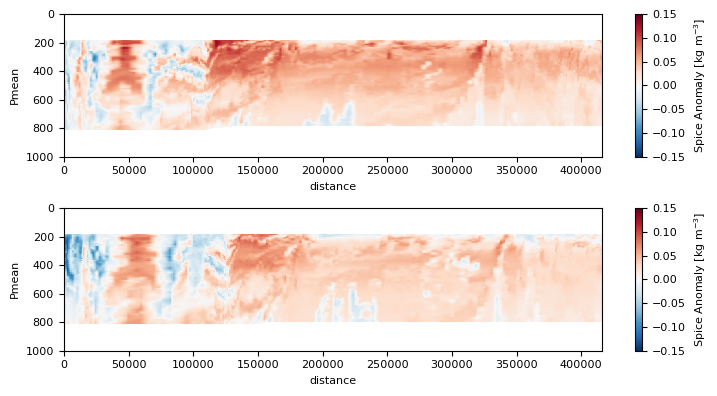

In [17]:
plt.figure(figsize=(7.5,4.))


plt.subplot(211)
(1000*spice_on_Pmean_659_sec).plot(vmin=-1.5e-1, rasterized=True, #interpolation= None,
                           cbar_kwargs={'label': 'Spice Anomaly [kg m$^{-3}$]'})
plt.gca().invert_yaxis()

#plt.ylim([800, 180]) # this is the range that is not super influenced by interplation.

plt.subplot(212)
(1000*spice_on_Pmean_660_sec).plot(vmin=-1.5e-1, rasterized=True, #interpolation= None,
                           cbar_kwargs={'label': 'Spice Anomaly [kg m$^{-3}$]'})
plt.gca().invert_yaxis()

plt.tight_layout()

Testing coherence calculations using numpy fft routines.

In [270]:
z = 400
x = np.reshape(spice_on_Pmean_659_sec.sel(Pmean=z, method='nearest').values.T, (4, 208) )
z0 = 400
y = np.reshape(spice_on_Pmean_659_sec.sel(Pmean=z0, method='nearest').values.T, (4, 208) )

In [271]:
Sxx = np.mean(np.fft.fft(x) * np.conj(np.fft.fft(x)), axis=0)
Syy = np.mean(np.fft.fft(y) * np.conj(np.fft.fft(y)), axis=0)
Sxy = np.mean(np.fft.fft(x) * np.conj(np.fft.fft(y)), axis=0)

In [275]:
cohr = np.abs(Sxy) / (Sxx**0.5 * Syy**0.5)

### Compute vertical coherence. 

In [344]:
spice_on_Pmean_659_sec_dft= xrft.fft(spice_on_Pmean_659_sec.isel(distance=slice(0,820)).chunk({'distance':82}),
                                     dim='distance', 
                                     true_phase=True, 
                                     true_amplitude=True, 
                                     window='hann',
                                     chunks_to_segments=True, 
                                     detrend='constant')

spice_on_Pmean_660_sec_dft= xrft.fft(spice_on_Pmean_660_sec.isel(distance=slice(0,820)).chunk({'distance':82}),
                                     dim='distance', 
                                     true_phase=True, 
                                     true_amplitude=True, 
                                     window='hann',
                                     chunks_to_segments=True, 
                                     detrend='constant')


/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/xrft/xrft.py:241: UserWarning: true_phase argument is ignored in xrft.fft
  warnings.warn("true_phase argument is ignored in xrft.fft")
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/xrft/xrft.py:243: UserWarning: true_amplitude argument is ignored in xrft.fft
  warnings.warn("true_amplitude argument is ignored in xrft.fft")
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/xrft/xrft.py:241: UserWarning: true_phase argument is ignored in xrft.fft
  warnings.warn("true_phase argument is ignored in xrft.fft")
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/xrft/xrft.py:243: UserWarning: true_amplitude argument is ignored in xrft.fft
  warnings.warn("true_amplitude argument is ignored in xrft.fft")


In [381]:
spice_on_Pmean_659_sec.distance[0:820]

<xarray.DataArray 'distance' (distance: 820)>
array([     0.,    500.,   1000., ..., 408500., 409000., 409500.])
Coordinates:
  * distance  (distance) float64 0.0 500.0 1e+03 ... 4.09e+05 4.095e+05

In [366]:
maxdz = 100
z0 = 300
zlevs = np.arange(z0-maxdz, z0+maxdz, 4)

cohr = np.zeros((len(spice_on_Pmean_659_sec_dft.freq_distance),  len(zlevs)))


for i, z in enumerate(zlevs):
    #print(z)
    Pz  = spice_on_Pmean_659_sec_dft.sel(Pmean=z, method='nearest')
    Pz0 = spice_on_Pmean_659_sec_dft.sel(Pmean=z0, method='nearest')

    Sxx_659 = (Pz * np.conj(Pz)).mean('distance_segment')
    Syy_659 = (Pz0 * np.conj(Pz0)).mean('distance_segment')
    Sxy_659 = (Pz* np.conj(Pz0)).mean('distance_segment')
    
    Pz  = spice_on_Pmean_660_sec_dft.sel(Pmean=z, method='nearest')
    Pz0 = spice_on_Pmean_660_sec_dft.sel(Pmean=z0, method='nearest')

    Sxx_660 = (Pz * np.conj(Pz)).mean('distance_segment')
    Syy_660 = (Pz0 * np.conj(Pz0)).mean('distance_segment')
    Sxy_660 = (Pz* np.conj(Pz0)).mean('distance_segment')
    
    Sxx = 0.5*(Sxx_659 + Sxx_660)
    Syy = 0.5*(Syy_659 + Syy_660)
    Sxy = 0.5*(Sxy_659 + Sxy_660)
    
    cohr[:, i] = np.abs(Sxy) / (np.sqrt(Sxx) * np.sqrt(Syy))

cohr_da_300 = xr.DataArray(cohr, dims=['freq_distance', 'dz'], coords={'freq_distance':spice_on_Pmean_659_sec_dft.freq_distance, 'dz':zlevs})
    

In [361]:
maxdz = 100
z0 = 500
zlevs = np.arange(z0-maxdz, z0+maxdz, 4)

cohr = np.zeros((len(spice_on_Pmean_659_sec_dft.freq_distance),  len(zlevs)))


for i, z in enumerate(zlevs):
    #print(z)
    Pz  = spice_on_Pmean_659_sec_dft.sel(Pmean=z, method='nearest')
    Pz0 = spice_on_Pmean_659_sec_dft.sel(Pmean=z0, method='nearest')

    Sxx_659 = (Pz * np.conj(Pz)).mean('distance_segment')
    Syy_659 = (Pz0 * np.conj(Pz0)).mean('distance_segment')
    Sxy_659 = (Pz* np.conj(Pz0)).mean('distance_segment')
    
    Pz  = spice_on_Pmean_660_sec_dft.sel(Pmean=z, method='nearest')
    Pz0 = spice_on_Pmean_660_sec_dft.sel(Pmean=z0, method='nearest')

    Sxx_660 = (Pz * np.conj(Pz)).mean('distance_segment')
    Syy_660 = (Pz0 * np.conj(Pz0)).mean('distance_segment')
    Sxy_660 = (Pz* np.conj(Pz0)).mean('distance_segment')
    
    Sxx = 0.5*(Sxx_659 + Sxx_660)
    Syy = 0.5*(Syy_659 + Syy_660)
    Sxy = 0.5*(Sxy_659 + Sxy_660)
    
    cohr[:, i] = np.abs(Sxy) / (np.sqrt(Sxx) * np.sqrt(Syy))

cohr_da_500 = xr.DataArray(cohr, dims=['freq_distance', 'dz'], coords={'freq_distance':spice_on_Pmean_659_sec_dft.freq_distance, 'dz':zlevs})
    

In [363]:
maxdz = 100
z0 = 670
zlevs = np.arange(z0-maxdz, z0+maxdz, 4)

cohr = np.zeros((len(spice_on_Pmean_659_sec_dft.freq_distance),  len(zlevs)))


for i, z in enumerate(zlevs):
    #print(z)
    Pz  = spice_on_Pmean_659_sec_dft.sel(Pmean=z, method='nearest')
    Pz0 = spice_on_Pmean_659_sec_dft.sel(Pmean=z0, method='nearest')

    Sxx_659 = (Pz * np.conj(Pz)).mean('distance_segment')
    Syy_659 = (Pz0 * np.conj(Pz0)).mean('distance_segment')
    Sxy_659 = (Pz* np.conj(Pz0)).mean('distance_segment')
    
    Pz  = spice_on_Pmean_660_sec_dft.sel(Pmean=z, method='nearest')
    Pz0 = spice_on_Pmean_660_sec_dft.sel(Pmean=z0, method='nearest')

    Sxx_660 = (Pz * np.conj(Pz)).mean('distance_segment')
    Syy_660 = (Pz0 * np.conj(Pz0)).mean('distance_segment')
    Sxy_660 = (Pz* np.conj(Pz0)).mean('distance_segment')
    
    Sxx = 0.5*(Sxx_659 + Sxx_660)
    Syy = 0.5*(Syy_659 + Syy_660)
    Sxy = 0.5*(Sxy_659 + Sxy_660)
    
    cohr[:, i] = np.abs(Sxy) / (np.sqrt(Sxx) * np.sqrt(Syy))

cohr_da_670 = xr.DataArray(cohr, dims=['freq_distance', 'dz'], coords={'freq_distance':spice_on_Pmean_659_sec_dft.freq_distance, 'dz':zlevs})
    

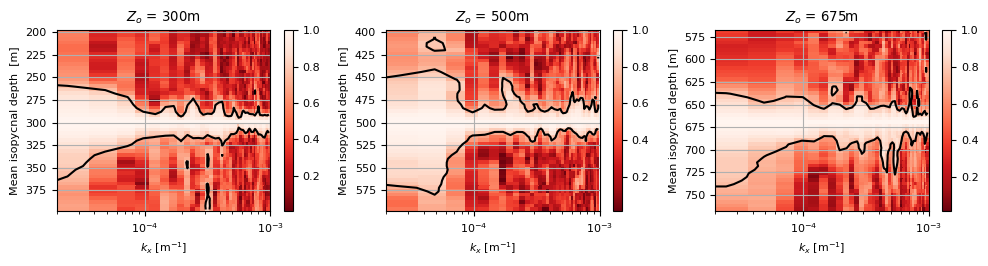

In [379]:
plt.figure(figsize=(10, 2.7))

plt.subplot(131)
cohr_da_300.plot(y='dz', cmap='Reds_r')
cohr_da_300.plot.contour(y='dz', levels=[0.75], colors='k')
plt.xscale('log')
plt.grid()
plt.xlabel('$k_x$ [m$^{-1}$]')
plt.ylabel('Mean isopycnal depth  [m]')
plt.title('$Z_o$ = 300m')
plt.gca().invert_yaxis()
plt.xlim([2e-5, 1e-3])

plt.subplot(132)
cohr_da_500.plot(y='dz', cmap='Reds_r')
cohr_da_500.plot.contour(y='dz', levels=[0.75], colors='k')
plt.xscale('log')
plt.grid()
plt.xlabel('$k_x$ [m$^{-1}$]')
plt.ylabel('Mean isopycnal depth  [m]')
plt.title('$Z_o$ = 500m')
plt.gca().invert_yaxis()
plt.xlim([2e-5, 1e-3])

plt.subplot(133)
cohr_da_670.plot(y='dz', cmap='Reds_r')
cohr_da_670.plot.contour(y='dz', levels=[0.75], colors='k')
plt.xscale('log')
plt.grid()
plt.xlabel('$k_x$ [m$^{-1}$]')
plt.ylabel('Mean isopycnal depth [m]')
plt.title('$Z_o$ = 675m')
plt.gca().invert_yaxis()
plt.xlim([2e-5, 1e-3])

plt.tight_layout()
plt.savefig('./figures/vertical_coherence.pdf')